# Base Line

In [23]:
import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

from scipy import interp

from sklearn.externals import joblib
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc
from IPython.display import display

import matplotlib.pyplot as plt
import seaborn as sns

from utils import *

In [2]:
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)
%load_ext autoreload
%autoreload 2
%matplotlib inline

## Load Data

In [3]:
train = joblib.load('models/train.joblib')
print(train.shape)

(307511, 317)


In [4]:
test = joblib.load('models/test.joblib')
print(test.shape)

(48744, 316)


In [5]:
targets = train['TARGET']
train_ids = train['SK_ID_CURR']
train.drop(columns=['SK_ID_CURR', 'TARGET'], inplace=True)

In [6]:
test_ids = test['SK_ID_CURR']
test = test.drop(columns=['SK_ID_CURR'])

## Drop redundand columns

In [7]:
cols_drop = appartment_mode_cols + appartment_medi_cols
train.drop(columns=cols_drop, inplace=True)
test.drop(columns=cols_drop, inplace=True)
print(train.shape)
print(test.shape)

(307511, 295)
(48744, 295)


## Model

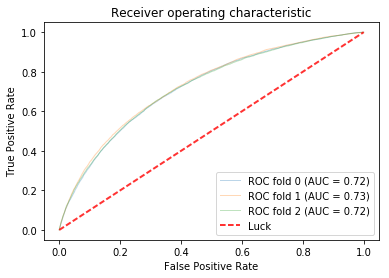

In [24]:
features = np.array(train)
test_features = np.array(test)

k_fold = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

i = 0
test_predictions = np.zeros(test_features.shape[0])

for train_indices, valid_indices in k_fold.split(features, targets):
    # Training data for the fold
    train_features, train_labels = features[train_indices], targets[train_indices]
    # Validation data for the fold
    valid_features, valid_labels = features[valid_indices], targets[valid_indices]
    
    model = LogisticRegression(C=0.001, class_weight='balanced', random_state=4242)
    probas_ = model.fit(train_features, train_labels).predict_proba(valid_features)
    test_predictions += model.predict_proba(test_features)[:, 1] / k_fold.n_splits

    fpr, tpr, thresholds = roc_curve(valid_labels, probas_[:, 1])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=1, alpha=0.3, label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))
    i += 1


plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Luck', alpha=.8)

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.figure(figsize=(7,5))
plt.show()

In [21]:
submission = pd.DataFrame({'SK_ID_CURR': test_ids, 'TARGET': test_predictions})
save_prediction(submission, 'LogisticRegression')

'kaggle competitions submit -c home-credit-default-risk -f /home/inc/work/edu/ndml/capstone/submissions/submission-LogisticRegression.csv -m "LogisticRegression"'